In [1]:
!conda install 'gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y 
# used to read and understand DICOM images

Preparing transaction: ...working... done
Verifying transaction: ...working... failed



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3




In [2]:
import numpy as np
import pandas as pd 
import os

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pydicom as dicom
!pip install opencv-python
import cv2
import ast
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
path = './kaggle/siim-covid19-detection/'
os.listdir(path)

['sample_submission.csv',
 'test',
 'train',
 'train_image_level.csv',
 'train_study_level.csv']

In [5]:
train_image = pd.read_csv(path+'train_image_level.csv')
train_study = pd.read_csv(path+'train_study_level.csv')
sample_submission = pd.read_csv(path+'sample_submission.csv')

### The image dataframe consists of all data regarding images

In [6]:
train_image.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


### The study dataframe consists of all data regarding studies

In [7]:
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


### Opacity is used to understand our images. Opacity is provided to us in the data using bounding boxes

In [8]:
OpacityCount = train_image['label'].str.count('opacity')
train_image['OpacityCount'] = OpacityCount.values
get_id = lambda x : x[0]
train_study['id'] = train_study['id'].str.split('_').apply(get_id)
train_study = train_study.rename({'id':'StudyInstanceUID'}, axis=1)
train_df = pd.merge(train_image, train_study, on='StudyInstanceUID')
train_df.head()

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0


In [9]:
# Get the image given the studyID
def get_image(i):
    long_path = path + 'train/' + train_df.loc[i, 'StudyInstanceUID'] + '/'
    img_id = train_df.loc[i, 'id'].replace('_image','.dcm')
    for dcm in os.listdir(long_path):
        dcm_path = long_path+dcm+'/'
        if img_id == os.listdir(dcm_path)[0]:
            data_file = dicom.dcmread(dcm_path+img_id)
            print('index : {} - DCM File Path :{}'.format(i, dcm_path+img_id))
        else:
            continue
            
    img = data_file.pixel_array
    return img

index : 0 - DCM File Path :./kaggle/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm


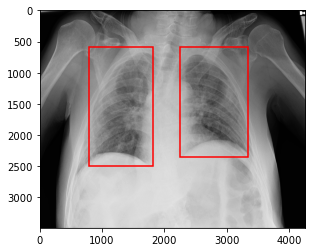

In [10]:
## A sample image with bounding boxes
sample_img = get_image(0)
boxes = ast.literal_eval(train_image.loc[0, 'boxes']) # function used to get coordinates of boxes
fig, ax = plt.subplots(1,1, figsize=(8,4))
for box in boxes:
    p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='r', fc='none', lw=1.5)
    ax.add_patch(p)
ax.imshow(sample_img, cmap='gray')
plt.show()

index : 0 - DCM File Path :./kaggle/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm
index : 1 - DCM File Path :./kaggle/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm
index : 2 - DCM File Path :./kaggle/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm
index : 3 - DCM File Path :./kaggle/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm
index : 4 - DCM File Path :./kaggle/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm
index : 5 - DCM File Path :./kaggle/siim-covid19-detection/train/84543edc24c2/82f65ab98ee0/0022227f5adf.dcm
index : 6 - DCM File Path :./kaggle/siim-covid19-detection/train/2fa400b873f5/0d5c637b277d/0023f02ae886.dcm
index : 7 - DCM File Path :./kaggle/siim-covid19-detection/train/0717c8ac304f/849b8c217a5e/002e9b2128d0.dcm
index : 8 - DCM File Path :./kaggle/siim-covid19-detection/train/a81050391441/85b77baa8ffe/00326161e51e.dcm


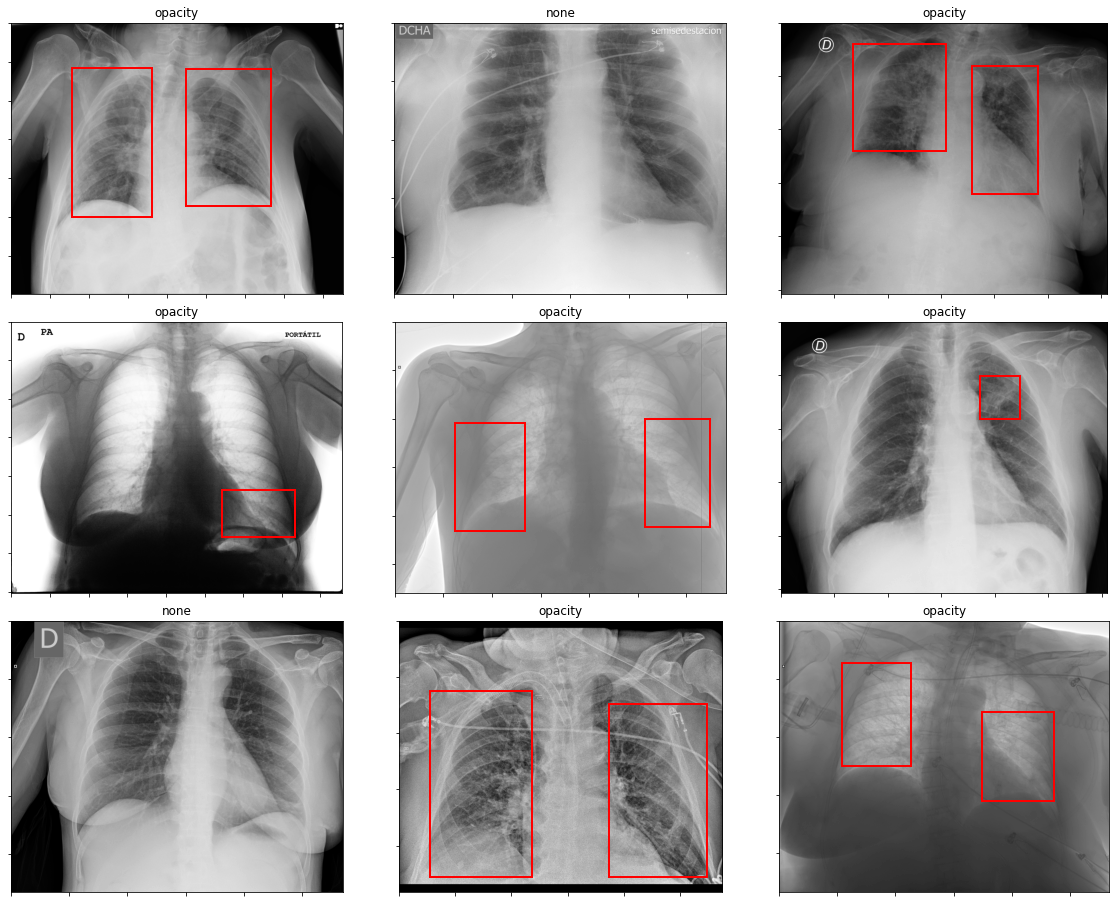

In [11]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()

for row in range(9):
    img = get_image(row)
    if (train_image.loc[row,'boxes'] == train_image.loc[row,'boxes']):
        boxes = ast.literal_eval(train_image.loc[row,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_image.loc[row, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])

In [12]:
# 4 types of opacity and basically the classes we need to predict
OpacityType = list(train_df.iloc[:,5:].columns)
OpacityType

['Negative for Pneumonia',
 'Typical Appearance',
 'Indeterminate Appearance',
 'Atypical Appearance']

### Opacity count tells us lot about the data and as we can see from the charts below it is somehow related to the classes Negative for Pneumonia, Typical Appearance, Indeterminate Appearance, Atypical Appearance but cannot be directly used due to the number of outliers. 

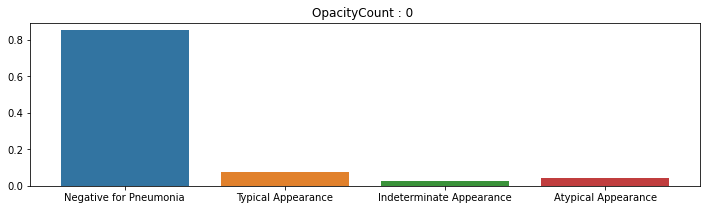

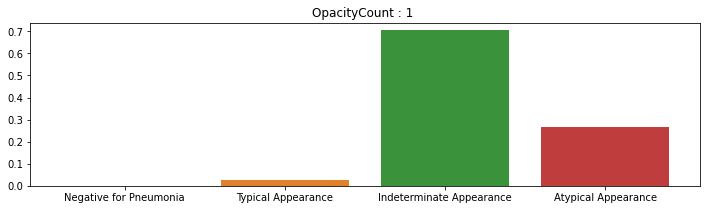

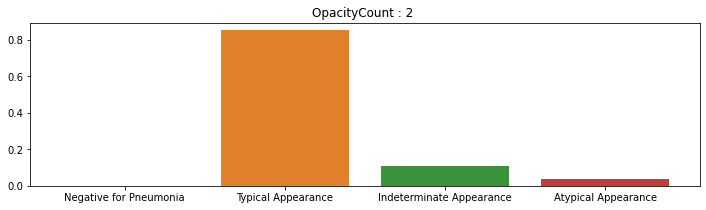

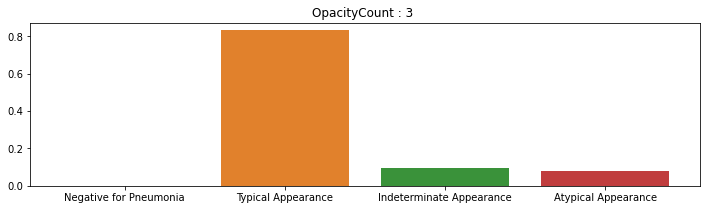

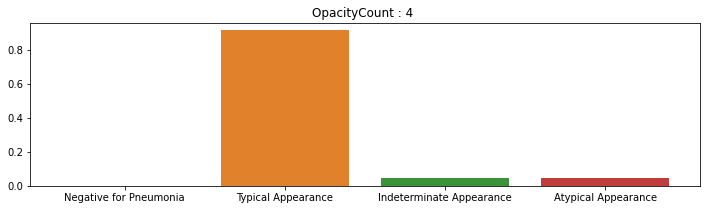

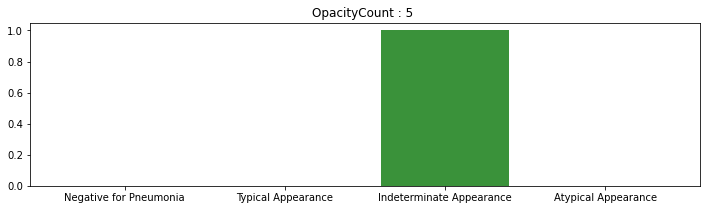

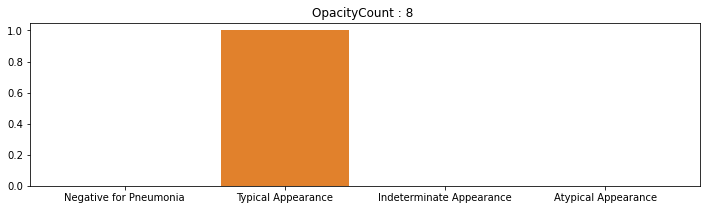

In [13]:
OpacityCount = sorted(list(train_df['OpacityCount'].value_counts().index))
for count in OpacityCount:
    Count_Series = train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum()
    fig = plt.figure(figsize=(12,3))
    sns.barplot(x=Count_Series.index, y=Count_Series.values/sum(train_df['OpacityCount']==count))
    plt.title('OpacityCount : {} '.format(count))
    plt.plot()

In [14]:
for count in OpacityCount:
    print('Opacity Count = {}\n------------------------------'.format(count))
    print(train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum())
    print(' ')

Opacity Count = 0
------------------------------
Negative for Pneumonia      1736
Typical Appearance           153
Indeterminate Appearance      59
Atypical Appearance           92
dtype: int64
 
Opacity Count = 1
------------------------------
Negative for Pneumonia        0
Typical Appearance           27
Indeterminate Appearance    685
Atypical Appearance         261
dtype: int64
 
Opacity Count = 2
------------------------------
Negative for Pneumonia         0
Typical Appearance          2653
Indeterminate Appearance     345
Atypical Appearance          115
dtype: int64
 
Opacity Count = 3
------------------------------
Negative for Pneumonia        0
Typical Appearance          152
Indeterminate Appearance     17
Atypical Appearance          14
dtype: int64
 
Opacity Count = 4
------------------------------
Negative for Pneumonia       0
Typical Appearance          21
Indeterminate Appearance     1
Atypical Appearance          1
dtype: int64
 
Opacity Count = 5
------------------

In [15]:
## Adding image path as a column to make processing faster
from glob import glob
path_list = []
for _, row in train_df.iterrows():
    image_id = row['id'].split('_')[0]
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{path}/train/{study_id}/*/{image_id}.dcm')
    if len(img_path)==1:
        path_list.append(img_path[0])
    else:
        print(img_path)
train_df['Path'] = path_list
train_df.head()

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0,./kaggle/siim-covid19-detection//train/5776db0...
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,./kaggle/siim-covid19-detection//train/ff0879e...
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0,./kaggle/siim-covid19-detection//train/9d514ce...
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,./kaggle/siim-covid19-detection//train/28dddc8...
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0,./kaggle/siim-covid19-detection//train/dfd9fdd...


### OpenCV  used to resize the image and rescale the pixel values i.e. normalize the values between 1-255

In [16]:
import cv2
def extract_resized_and_origin_img_info(path_list):
    img_list = []
    origin_img_heights = []
    origin_img_widths = []
    for path in path_list:
        data_file = dicom.read_file(path)
        img = data_file.pixel_array

            
        origin_img_heights.append(img.shape[0])
        origin_img_widths.append(img.shape[1])

        
        img = (img - np.min(img)) / np.max(img)
        img = (img * 255).astype(np.uint8)
        
        img = cv2.resize(img, (150,150))
        img_list.append(img)
        img_array = np.array(img_list)
            
    return img_array, origin_img_heights, origin_img_widths

test_imgs, origin_img_heights, origin_img_widths = extract_resized_and_origin_img_info(path_list[:10])
data_file = dicom.read_file(path_list[0])
x_scale_list=[]
y_scale_list=[]

if len(origin_img_heights) == len(origin_img_widths):
    for i in range(len(origin_img_heights)):
        x_scale = 150 / origin_img_widths[i]
        x_scale_list.append(x_scale)
        y_scale = 150 / origin_img_heights[i]
        y_scale_list.append(y_scale)

## As we can see below these are the rescaled and resized images

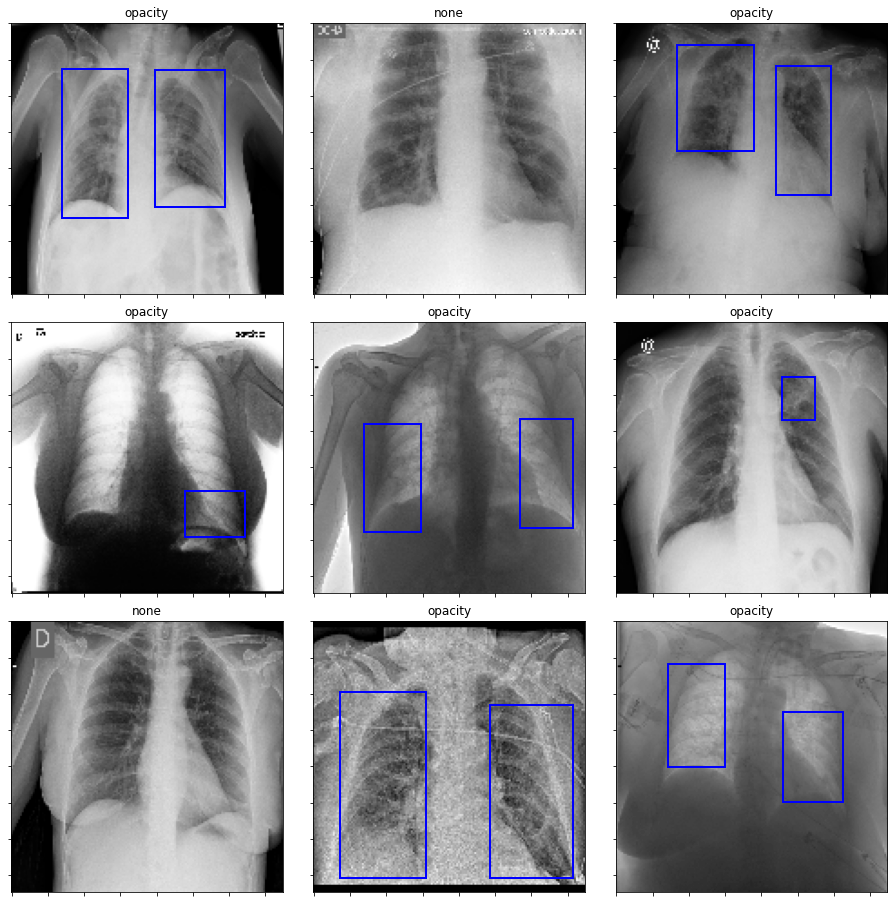

In [17]:
fig, axes = plt.subplots(3,3, figsize=(16,16))
fig.subplots_adjust(hspace=.1, wspace=.05)
axes = axes.ravel()
row = 0
for index in range(9):
    img = test_imgs[index]
    if (train_df.loc[index,'boxes'] == train_df.loc[index,'boxes']):
        boxes = ast.literal_eval(train_df.loc[index,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x']*x_scale_list[index], box['y']*y_scale_list[index]),
                                              box['width']*x_scale_list[index], box['height']*y_scale_list[index],
                                              ec='b', fc='none', lw=2.)
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[index, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

In [18]:
## Adding a binary feature to show the presence of any number of opacity
train_df['Opacity'] = train_df.apply(lambda row : 1 if row.label.split(' ')[0]=='opacity' else 0, axis=1)
train_df

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Path,Opacity
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0,./kaggle/siim-covid19-detection//train/5776db0...,1
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,./kaggle/siim-covid19-detection//train/ff0879e...,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0,./kaggle/siim-covid19-detection//train/9d514ce...,1
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,./kaggle/siim-covid19-detection//train/28dddc8...,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0,./kaggle/siim-covid19-detection//train/dfd9fdd...,1
...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0,./kaggle/siim-covid19-detection//train/7e6c684...,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,0,1,0,0,0,./kaggle/siim-covid19-detection//train/8332bda...,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,3,0,1,0,0,./kaggle/siim-covid19-detection//train/7eed9af...,1
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,2,0,1,0,0,./kaggle/siim-covid19-detection//train/a0cb0b9...,1


### Meta data of images consisting of:
#### 1.image_id - id of the image
#### 2.dim0 -  width of the image
#### 3.dim1 - height of the image
#### 4.split -  one of two (train, test)

In [19]:
meta_df = pd.read_csv('./kaggle/input/meta.csv')

In [20]:
train_meta_df = meta_df.loc[meta_df.split=='train']
train_meta_df.drop('split',axis=1,inplace=True)
train_meta_df.columns = ['id', 'origin_img_height','origin_img_width']
train_meta_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6334 entries, 1263 to 7596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 6334 non-null   object
 1   origin_img_height  6334 non-null   int64 
 2   origin_img_width   6334 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 197.9+ KB


In [21]:
## Splicing the unwanted part of id
train_df['id'] = train_df['id'].apply(lambda x : x.split('_')[0])
train_df = pd.merge(train_df, train_meta_df, on='id')
train_df.head()

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Path,Opacity,origin_img_height,origin_img_width
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0,./kaggle/siim-covid19-detection//train/5776db0...,1,3488,4256
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,./kaggle/siim-covid19-detection//train/ff0879e...,0,2320,2832
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0,./kaggle/siim-covid19-detection//train/9d514ce...,1,2544,3056
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,./kaggle/siim-covid19-detection//train/28dddc8...,1,3520,4280
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0,./kaggle/siim-covid19-detection//train/dfd9fdd...,1,2800,3408


In [22]:
path = './kaggle/input/train/'
train_imgs_path = list(train_df['id'].apply(lambda x : path + x + '.jpg').values)
train_imgs = []
for img_path in train_imgs_path:
    img = plt.imread(img_path)
    train_imgs.append(img)

In [23]:
train_imgs = np.array(train_imgs)

In [24]:
train_df['height_ratio'] = train_df['origin_img_height'].apply(lambda x : 255/x)

In [25]:
train_df['width_ratio'] = train_df['origin_img_width'].apply(lambda x : 255/x)

#### Creating folders for each class to make the training process faster

In [26]:
os.makedirs("genData")
os.makedirs("./genData/Negative")
os.makedirs("./genData/Typical")
os.makedirs("./genData/Indeterminate")
os.makedirs("./genData/Atypical")

In [27]:
def sort_images_store(type_index, path):
    types = list(train_df.columns[5:9])
    imgs_Negative = list(train_df[train_df[types[type_index]]==1].index)
    for idx in imgs_Negative:
        save_path = './genData/'+path+'/{}.jpg'
        plt.imsave(save_path.format(train_df.loc[idx,'id']), train_imgs[idx], cmap='gray')
    
sort_images_store(0,'Negative')
sort_images_store(1,'Typical')
sort_images_store(2,'Indeterminate')
sort_images_store(3,'Atypical')

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='reflect',
    validation_split=0.2
)
data_path = './genData'
batch_size = 64
target_size = (256, 256)
class_mode = 'categorical'
color_mode = 'grayscale'
train_gen = idg.flow_from_directory(
    data_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode=class_mode,
    color_mode=color_mode,
    subset = 'training'
)

valid_gen = idg.flow_from_directory(
    data_path,
    batch_size = batch_size,
    target_size = target_size,
    class_mode = class_mode,
    color_mode=color_mode,
    subset = 'validation'
)

Found 5069 images belonging to 4 classes.
Found 1265 images belonging to 4 classes.


In [29]:
!pip install pydot
!pip install graphviz
from keras.utils.vis_utils import plot_model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(256, 256,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [32]:
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath = filepath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1
)

In [33]:
epochs = 1
model.fit(
    train_gen,
    validation_data = (valid_gen),
    epochs = epochs,
    callbacks=[cp]
)

80/80 [==============================] - 210s 3s/step - loss: 1.2188 - acc: 0.4750 - val_loss: 1.1915 - val_acc: 0.4838

Epoch 00001: val_loss improved from inf to 1.19152, saving model to my_checkpoint.ckpt


In [34]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy is:", accuracy)

20/20 [==============================] - 11s 525ms/step - loss: 1.1894 - acc: 0.4854
Accuracy is: 0.4853754937648773


#### The above model is a standard convolutional neural network model and has an accuracy of around 0.475 which can definitely be improved

In [35]:
idg = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='reflect',
    validation_split=0.2
)
data_path = './genData'
batch_size = 64
target_size = (224, 224)
class_mode = 'categorical'
color_mode = 'grayscale'
train_gen = idg.flow_from_directory(
    data_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode=class_mode,
    color_mode=color_mode,
    subset = 'training'
)

valid_gen = idg.flow_from_directory(
    data_path,
    batch_size = batch_size,
    target_size = target_size,
    class_mode = class_mode,
    color_mode=color_mode,
    subset = 'validation'
)

Found 5069 images belonging to 4 classes.
Found 1265 images belonging to 4 classes.


In [36]:
from tensorflow.keras.applications import EfficientNetB0
efc = EfficientNetB0(weights='imagenet',
                     include_top=False, 
                     input_shape=(224,224,3),
                     drop_connect_rate=0.4)
efc.trainable=False
model = Sequential([
    efc,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])
model.summary() 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
filepath = 'my_checkpoint_efc_224.ckpt'
cp = ModelCheckpoint(
    filepath = filepath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1
)
model.fit(
    train_gen,
    validation_data=(valid_gen),
    epochs=epochs,
    callbacks=[cp]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16056576  
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 20,107,175
Trainable params: 16,057,604
Non-trainable params: 4,049,571
_________________________________________________________________
80/80 [==============================] - 115s 1s/step - loss: 3.1459 - acc: 0.5413 - val_loss: 1.123

In [37]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy is:", accuracy)

20/20 [==============================] - 22s 1s/step - loss: 1.1205 - acc: 0.5874
Accuracy is: 0.5873517990112305


#### As we can see the EfficientNet model performs way better than the CNN model

In [38]:
from tensorflow.keras.applications import EfficientNetB3
efc = EfficientNetB3(weights='imagenet',
                     include_top=False, 
                     input_shape=(224,224,3),
                     drop_connect_rate=0.4)
efc.trainable=False
model = Sequential([
    efc,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])
model.summary() 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
filepath = 'my_checkpoint_efc_224.ckpt'
cp = ModelCheckpoint(
    filepath = filepath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1
)
model.fit(
    train_gen,
    validation_data=(valid_gen),
    epochs=epochs,
    callbacks=[cp]
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
flatten_2 (Flatten)          (None, 75264)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 75264)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               19267840  
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 30,052,403
Trainable params: 19,268,868
Non-trainable params: 10,783,535
_________________________________________________________________
80/80 [==============================] - 214s 3s/step - loss: 3.0492 - acc: 0.5244 - val_loss: 1.11

In [ ]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy is:", accuracy)

16/20 [=======================>......] - ETA: 8s - loss: 1.0669 - acc: 0.6104 

In [ ]:
from tensorflow.keras.applications import EfficientNetB5
efc = EfficientNetB5(weights='imagenet',
                     include_top=False, 
                     input_shape=(224,224,3),
                     drop_connect_rate=0.4)
efc.trainable=False
model = Sequential([
    efc,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])
model.summary() 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
filepath = 'my_checkpoint_efc_224.ckpt'
cp = ModelCheckpoint(
    filepath = filepath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1
)
model.fit(
    train_gen,
    validation_data=(valid_gen),
    epochs=epochs,
    callbacks=[cp]
)

In [ ]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy is:", accuracy)

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
efc = EfficientNetB7(weights='imagenet',
                     include_top=False, 
                     input_shape=(224,224,3),
                     drop_connect_rate=0.4)
efc.trainable=False
model = Sequential([
    efc,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])
model.summary() 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
filepath = 'my_checkpoint_efc_224.ckpt'
cp = ModelCheckpoint(
    filepath = filepath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1
)
model.fit(
    train_gen,
    validation_data=(valid_gen),
    epochs=epochs,
    callbacks=[cp]
)

In [ ]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy is:", accuracy)